## Some playaround with SVM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

input_path_thyroid = '../../input/uci_thyroid'
tsh_transform = lambda x: np.log(1e-5 + x)
col_names = [
    'age', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication',
    'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid',
    'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
    'psych', 'TSH', 'T3', 'TT4', 'T4U', 
    'FTI'
]
class_names = ['normal', 'hyper', 'hypo']
df_thyr = [
    pd.read_csv(
        f'{input_path_thyroid}/ann-{tag}.data', header=None, names=col_names+['class'],
        delim_whitespace=True
    )
    for tag in ['train', 'test']
]
df_thyr = pd.concat([
    pd.concat(df_thyr, axis=0, ignore_index=True), 
    pd.Series([0]*len(df_thyr[0]) + [1]*len(df_thyr[1]), name='test')
], axis=1)
df_thyr = df_thyr.drop_duplicates()
del df_thyr['hypopituitary']
# df_thyr['TSH_log'] = tsh_transform(df_thyr['TSH_log'])

df_thyr_train, df_thyr_test = df_thyr[df_thyr['test'] == 0], df_thyr[df_thyr['test'] == 1]

X_train, y_train = df_thyr_train.iloc[:, :-2], df_thyr_train['class']
X_test,  y_test  =  df_thyr_test.iloc[:, :-2],  df_thyr_test['class']

### A small experiment with sklearn.preprocessing.PowerTransformer

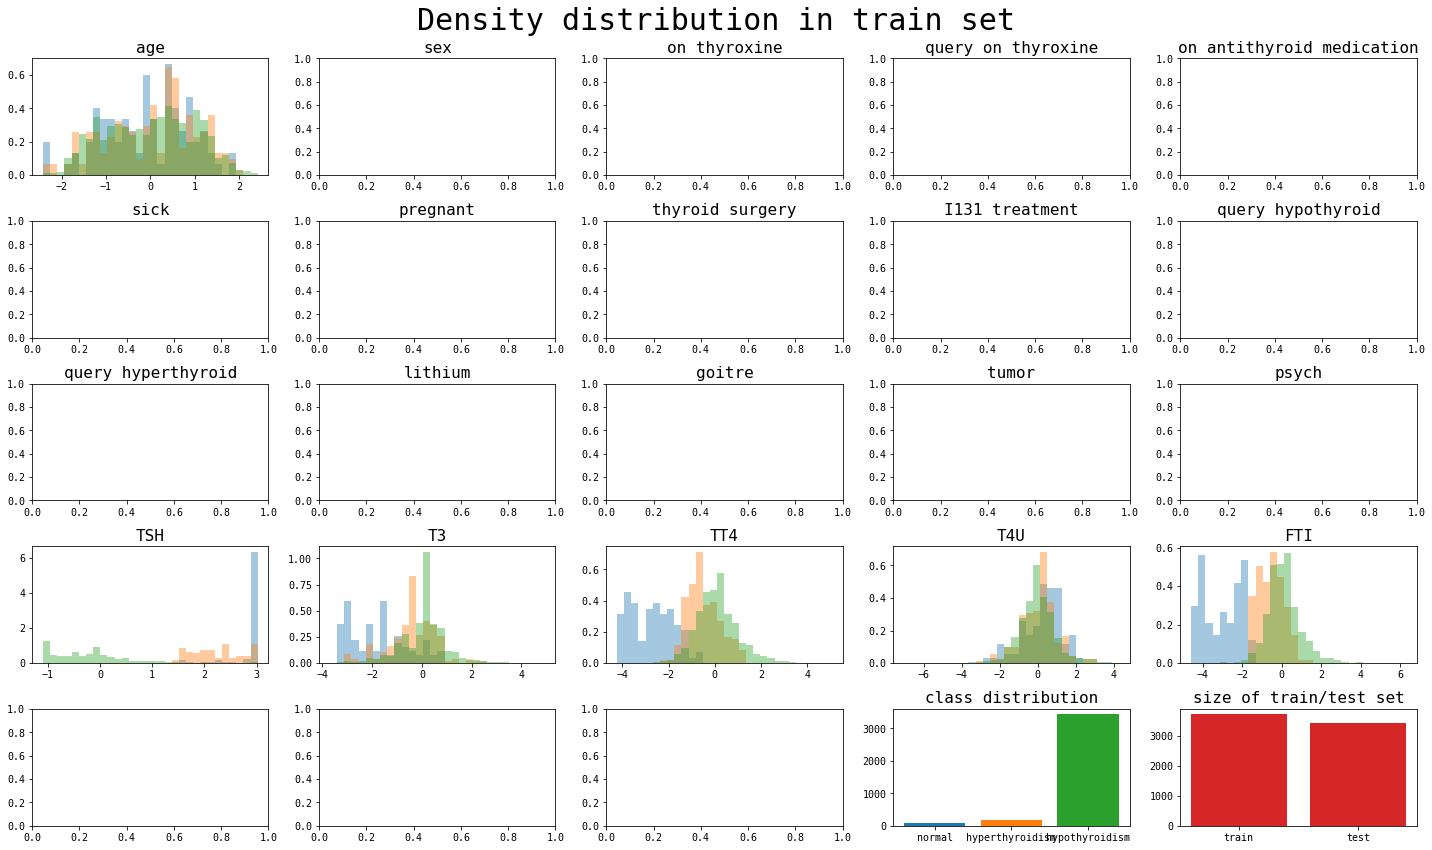

In [2]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

X_pt_train = pt.fit_transform(X_train)
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 12))
axs = axs.ravel()
for num, name in enumerate(df_thyr.columns[:-2]):
    ax = axs[num]
    title = name
    ser_all = X_pt_train[:, num]
    _, bins = np.histogram(ser_all, bins=30)
    alpha = 0.4
    for j in range(1, 1+3):
        ser = ser_all[df_thyr_train['class'] == j]
        if name in ['TSH', 'age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']:
            ax.hist(ser, bins=bins, density=True, color=f'C{j-1}', alpha=alpha)
        # else:
        #     ax.bar(np.sort(np.unique(ser)), ser.value_counts(normalize=True).sort_index(), color=f'C{j-1}', alpha=alpha)
    ax.set_title(title, fontsize=16)

ax = axs[-2]
for j in range(1, 1+3):
    ax.bar([j], [(df_thyr_train['class'] == j).sum()], color=f'C{j-1}')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['normal', 'hyperthyroidism', 'hypothyroidism'])
ax.set_title('class distribution', fontsize=16)

ax = axs[-1]
ax.bar(['train', 'test'], [(df_thyr['test'] == 0).sum(), (df_thyr['test'] == 1).sum()], color='C3')
ax.set_title('size of train/test set', fontsize=16)

fig.suptitle('Density distribution in train set', fontsize=30)
plt.tight_layout()
plt.show(); plt.close()

### SVCs: linear, rbf, poly, sigmoid

In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import itertools

1. linear kernel

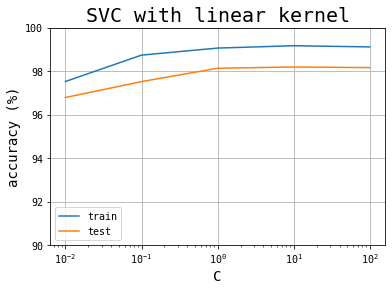

In [4]:
acc_trains, acc_tests = [], [] 
Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2]
kernels = ['linear']
for C, kernel in itertools.product(Cs, kernels):
    model = make_pipeline(
        PowerTransformer(),
        SVC(
            C=C,
            kernel=kernel,
            random_state=42
        )
    )
    model.fit(X_train, y_train)

    acc_train = 100*accuracy_score(y_train, model.predict(X_train))
    acc_test = 100*accuracy_score(y_test, y_pred := model.predict(X_test))
    acc_trains.append(acc_train)
    acc_tests.append(acc_test)
plt.plot(Cs, acc_trains, label='train'); plt.plot(Cs, acc_tests, label='test'); 
plt.xlabel('C', fontsize=14); plt.xscale('log')
plt.ylabel('accuracy (%)', fontsize=14); plt.ylim(90, 100); plt.grid(); plt.legend()
plt.title('SVC with linear kernel', fontsize=20)
plt.show(); plt.close()

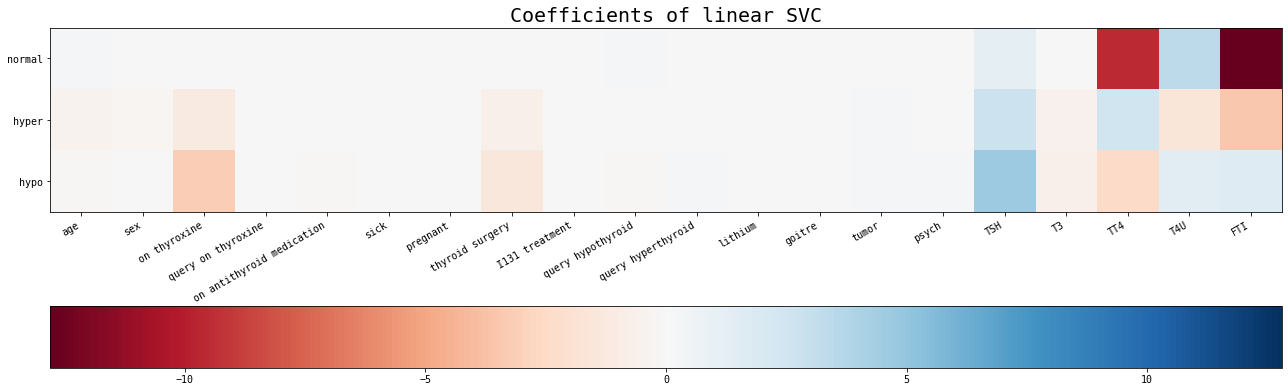

In [5]:
coef = model[-1].coef_
m = np.max(np.abs(coef))

fig, ax = plt.subplots(figsize=(18, 9))
img = plt.imshow(coef, vmin=-m, vmax=m, cmap='RdBu')
plt.colorbar(img, orientation='horizontal')
ax.set_xticks(np.arange(X_train.shape[1]))
ax.set_xticklabels(X_train.columns, ha='right', rotation=30)
ax.set_yticks(np.arange(3))
ax.set_yticklabels(['normal', 'hyper', 'hypo'])
ax.set_title('Coefficients of linear SVC', fontsize=20)
plt.tight_layout(); plt.show(); plt.close()

2. radial bmp kernel

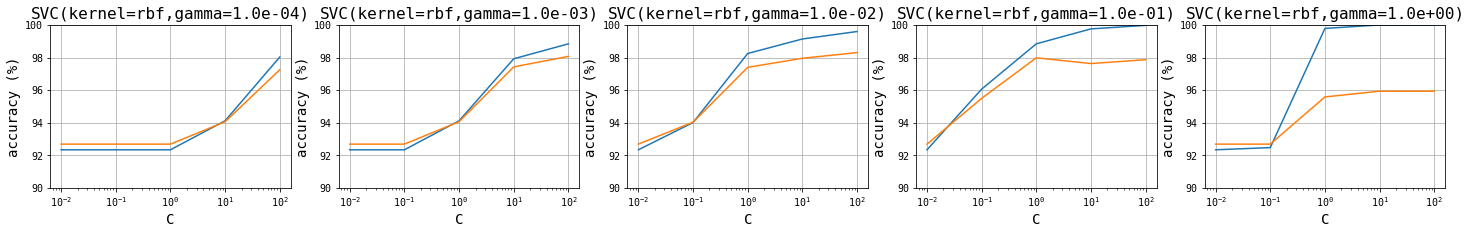

In [6]:
fig, axs = plt.subplots(ncols=5, figsize=(25, 3))

gammas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
for gamma, ax in zip(gammas, axs):
    acc_trains, acc_tests = [], [] 
    Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2]
    kernels = ['rbf']
    for C, kernel in itertools.product(Cs, kernels):
        model = make_pipeline(
            PowerTransformer(),
            SVC(
                C=C,
                kernel=kernel,
                gamma=gamma,
                random_state=42
            )
        )
        model.fit(X_train, y_train)

        acc_train = 100*accuracy_score(y_train, model.predict(X_train))
        acc_test = 100*accuracy_score(y_test, y_pred := model.predict(X_test))
        acc_trains.append(acc_train)
        acc_tests.append(acc_test)
    
    ax.plot(Cs, acc_trains, label='train'); ax.plot(Cs, acc_tests, label='test'); 
    ax.set_xlabel('C', fontsize=14); ax.set_xscale('log')
    ax.set_ylabel('accuracy (%)', fontsize=14); ax.set_ylim(90, 100); ax.grid()
    ax.set_title(f'SVC(kernel={kernel},gamma={gamma:.1e})', fontsize=16)
plt.show(); plt.close()

3. polynomial kernel

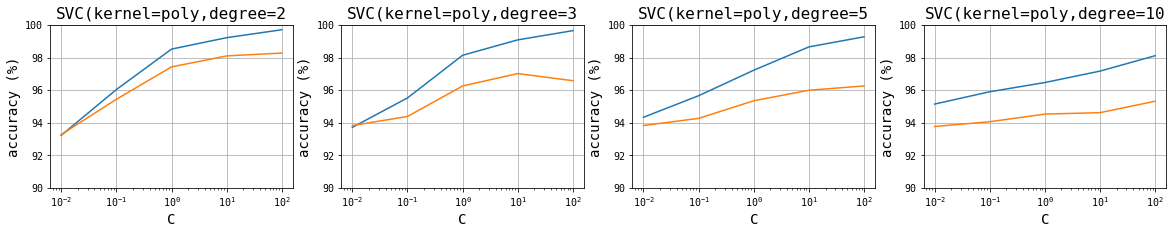

In [7]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 3))

degrees = [2, 3, 5, 10]
for degree, ax in zip(degrees, axs):
    acc_trains, acc_tests = [], [] 
    Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2]
    kernels = ['poly']
    for C, kernel in itertools.product(Cs, kernels):
        model = make_pipeline(
            PowerTransformer(),
            SVC(
                C=C,
                kernel=kernel,
                degree=degree,
                random_state=42
            )
        )
        model.fit(X_train, y_train)

        acc_train = 100*accuracy_score(y_train, model.predict(X_train))
        acc_test = 100*accuracy_score(y_test, y_pred := model.predict(X_test))
        acc_trains.append(acc_train)
        acc_tests.append(acc_test)
    
    ax.plot(Cs, acc_trains, label='train'); ax.plot(Cs, acc_tests, label='test'); 
    ax.set_xlabel('C', fontsize=14); ax.set_xscale('log')
    ax.set_ylabel('accuracy (%)', fontsize=14); ax.set_ylim(90, 100); ax.grid()
    ax.set_title(f'SVC(kernel={kernel},degree={degree}', fontsize=16)
plt.show(); plt.close()

4. sigmoid kernel

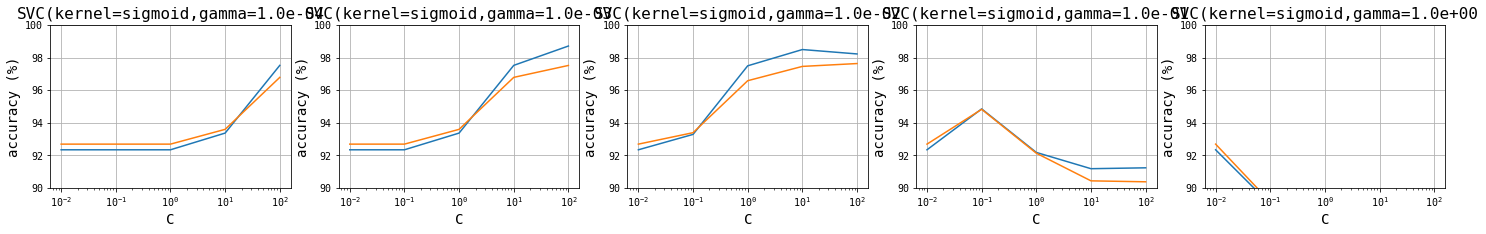

In [15]:
fig, axs = plt.subplots(ncols=5, figsize=(25, 3))

gammas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
for gamma, ax in zip(gammas, axs):
    acc_trains, acc_tests = [], [] 
    Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2]
    kernels = ['sigmoid']
    for C, kernel in itertools.product(Cs, kernels):
        model = make_pipeline(
            PowerTransformer(),
            SVC(
                C=C,
                kernel=kernel,
                gamma=gamma,
                random_state=42
            )
        )
        model.fit(X_train, y_train)

        acc_train = 100*accuracy_score(y_train, model.predict(X_train))
        acc_test = 100*accuracy_score(y_test, y_pred := model.predict(X_test))
        acc_trains.append(acc_train)
        acc_tests.append(acc_test)
        
    ax.plot(Cs, acc_trains, label='train'); ax.plot(Cs, acc_tests, label='test'); 
    ax.set_xlabel('C', fontsize=14); ax.set_xscale('log')
    ax.set_ylabel('accuracy (%)', fontsize=14); ax.set_ylim(90, 100); ax.grid()
    ax.set_title(f'SVC(kernel={kernel},gamma={gamma:.1e}', fontsize=16)
plt.show(); plt.close()

appendix: what if `class_weight='balanced'`?

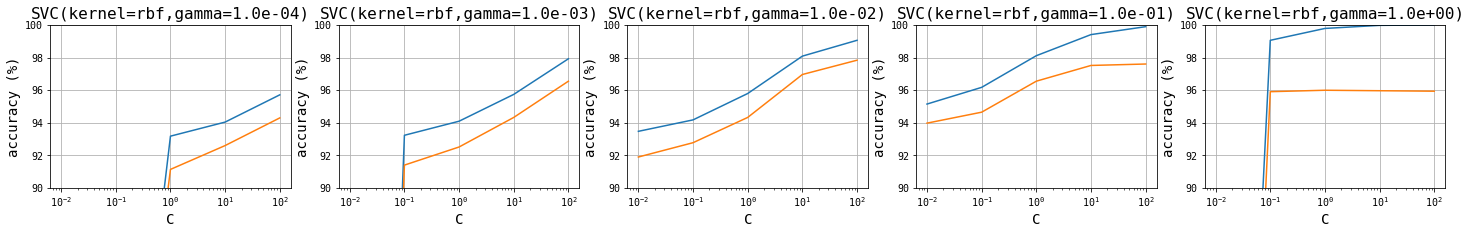

In [19]:
fig, axs = plt.subplots(ncols=5, figsize=(25, 3))

gammas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
for gamma, ax in zip(gammas, axs):
    acc_trains, acc_tests = [], [] 
    Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2]
    kernels = ['rbf']
    for C, kernel in itertools.product(Cs, kernels):
        model = make_pipeline(
            PowerTransformer(),
            SVC(
                C=C,
                kernel=kernel,
                gamma=gamma,
                class_weight='balanced',
                random_state=42
            )
        )
        model.fit(X_train, y_train)

        acc_train = 100*accuracy_score(y_train, model.predict(X_train))
        acc_test = 100*accuracy_score(y_test, y_pred := model.predict(X_test))
        acc_trains.append(acc_train)
        acc_tests.append(acc_test)
    
    ax.plot(Cs, acc_trains, label='train'); ax.plot(Cs, acc_tests, label='test'); 
    ax.set_xlabel('C', fontsize=14); ax.set_xscale('log')
    ax.set_ylabel('accuracy (%)', fontsize=14); ax.set_ylim(90, 100); ax.grid()
    ax.set_title(f'SVC(kernel={kernel},gamma={gamma:.1e})', fontsize=16)
plt.show(); plt.close()

### How to set hyperparameters: hyperparameter tuning

In [18]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous

param_grid = {
    'svc__C': Continuous(1e-2, 1e2, distribution='log-uniform', random_state=42),
    'svc__kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid'], random_state=42),
    'svc__degree': Integer(2, 20, random_state=42),
    'svc__gamma': Continuous(1e-4, 1e0, distribution='log-uniform', random_state=42)
}

ga_cv = GASearchCV(
    model,
    cv=10,
    param_grid=param_grid,
    population_size=10,
    generations=20,
    scoring='accuracy',
)
ga_cv.fit(X_train, y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.959342	0.0351333  	0.986788   	0.873551   
1  	20    	0.97595 	0.0194998  	0.986788   	0.92343    
2  	20    	0.984739	0.00527547 	0.986788   	0.968993   
3  	20    	0.986788	0          	0.986788   	0.986788   
4  	20    	0.986788	0          	0.986788   	0.986788   
5  	20    	0.986788	0          	0.986788   	0.986788   
6  	20    	0.986788	0          	0.986788   	0.986788   
7  	20    	0.986788	0          	0.986788   	0.986788   
8  	20    	0.986788	7.02167e-17	0.986788   	0.986788   
9  	20    	0.985413	0.00412574 	0.986788   	0.973036   
10 	20    	0.986788	0          	0.986788   	0.986788   
11 	20    	0.986788	0          	0.986788   	0.986788   
12 	20    	0.986033	0.00226481 	0.986788   	0.979239   
13 	20    	0.985818	0.00228522 	0.986788   	0.979239   
14 	20    	0.986788	0          	0.986788   	0.986788   
15 	20    	0.986653	0.000404094	0.986788   	0.985441   
16 	20    	0.986519	0.000538792	0.986788   	0.98

GASearchCV(cv=10,
           estimator=Pipeline(steps=[('powertransformer', PowerTransformer()),
                                     ('svc',
                                      SVC(C=21.41473893047776, degree=9,
                                          gamma=0.1298775203222132,
                                          kernel='linear', random_state=42))]),
           generations=20,
           param_grid={'svc__C': <sklearn_genetic.space.space.Continuous object at 0x000002A83B89B670>,
                       'svc__degree': <sklearn_genetic.space.space.Integer object at 0x000002A8395DCE20>,
                       'svc__gamma': <sklearn_genetic.space.space.Continuous object at 0x000002A8395DC1F0>,
                       'svc__kernel': <sklearn_genetic.space.space.Categorical object at 0x000002A8395DC670>},
           population_size=10, return_train_score=True, scoring='accuracy')

In [20]:
accuracy_score(y_test, ga_cv.best_estimator_.predict(X_test))

0.9815789473684211